# 0. Install required packages

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install selenium

In [ ]:
!pip install selenium_stealth

In [ ]:
from requests import get
from bs4 import BeautifulSoup
from bs4 import Comment

import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Data wrangling
- NBA Stats API
- Basketball Reference Webscraping

In [ ]:
from nba_api.stats.endpoints import playercareerstats

# Nikola Jokić
career = playercareerstats.PlayerCareerStats(player_id='203999') 

# pandas data frames (optional: pip install pandas)
career.get_data_frames()[0].head()

,PLAYER_ID,SEASON_ID,LEAGUE_ID,TEAM_ID,TEAM_ABBREVIATION,PLAYER_AGE,GP,GS,MIN,FGM,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS
0,203999,2015-16,00,1610612743,DEN,21.0,80,55,1733.0,307,...,0.811,181,379,560,189,79,50,104,208,796
1,203999,2016-17,00,1610612743,DEN,22.0,73,59,2038.0,494,...,0.825,212,506,718,359,61,55,171,214,1221
2,203999,2017-18,00,1610612743,DEN,23.0,75,73,2443.0,504,...,0.850,195,608,803,458,90,61,210,212,1385
3,203999,2018-19,00,1610612743,DEN,24.0,80,80,2504.0,616,...,0.821,228,637,865,580,108,55,248,228,1604
4,203999,2019-20,00,1610612743,DEN,25.0,73,73,2335.0,565,...,0.817,166,545,711,512,85,44,226,222,1456


Scraping the Baseketball Reference Website was troublesome in the beginning due to the cybersecurity system. Selenium, a browswer automation tool, was used to help us bypass the system.

In [ ]:
import time
from selenium import webdriver
from selenium_stealth import stealth
from selenium.webdriver.common.by import By
from bs4 import BeautifulSoup
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

In [ ]:
# from basketball reference

url_format = 'https://www.basketball-reference.com/awards/awards_{}.html'
 
options=webdriver.ChromeOptions()
 
options.add_argument("start-maximized")
#options.add_argument("--headless")
options.add_experimental_option("excludeSwitches", ["enable-automation"])
options.add_experimental_option('useAutomationExtension', False)
options.add_argument("--disable-blink-features=AutomationControlled")
driver = webdriver.Chrome(options=options)


def get_dpoy_df(year):
    driver.get(url_format.format(year))

    time.sleep(10)
    # element = WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CLASS_NAME, 'load-more')))
    html_soup = BeautifulSoup(driver.page_source, 'html.parser')
    
    # response = get(url_format.format(year))
    # html_soup = BeautifulSoup(response.text,'html.parser')
    comment_dpoy = html_soup.find_all('div',id='all_dpoy')[0].find_all(string=lambda text: isinstance(text, Comment))[0]
    
    dpoy_soup = BeautifulSoup(str(comment_dpoy),'html.parser')
    table_dpoy = dpoy_soup.find_all('tr')

    header = table_dpoy[1].find_all('th')[1:] # neglect rank
    header = [h.text.strip() for h in header] + ['Year', 'Link']
    
    dpoy_dict= {h:[] for h in header}
    table_rows = table_dpoy[2:]

    for row in table_rows:
        data = row.findAll('td')
        # data cleaning
        data_cleaned = [d.text for d in data]

        for h, d in zip(header, data_cleaned):
            dpoy_dict[h].append(d)

        dpoy_dict['Year'].append(year)
        dpoy_dict['Link'].append(data[0].a['href'])

    return pd.DataFrame(dpoy_dict)

def get_dpoy_df_from_range(start, end):
    return pd.concat([get_dpoy_df(y) for y in range(start, end+1)])

df_dpoy = get_dpoy_df_from_range(1984, 2022)
df_dpoy.to_csv('dpoy_1984_2022.csv', index = False, encoding='utf-8')
df_dpoy.head()


In [ ]:
options=webdriver.ChromeOptions()
 
options.add_argument("start-maximized")
#options.add_argument("--headless")
options.add_experimental_option("excludeSwitches", ["enable-automation"])
options.add_experimental_option('useAutomationExtension', False)
options.add_argument("--disable-blink-features=AutomationControlled")
driver = webdriver.Chrome(options=options)


def get_player_stats(year):
    url_format = 'https://www.basketball-reference.com/leagues/NBA_{}_per_game.html'

    driver.get(url_format.format(year))

    time.sleep(10)
    # element = WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CLASS_NAME, 'load-more')))
    html_soup = BeautifulSoup(driver.page_source, 'html.parser')
    
    player_per_games_stats = html_soup.find_all('div',id='all_per_game_stats')[0].find_all('div',id='div_per_game_stats')[0].find_all('table')[0]

    header = player_per_games_stats.find('thead').find('tr').find_all('th')[1:] # neglect rank
    header = [h.text.strip() for h in header] + ['Year']

    table_player_stats = player_per_games_stats.find('tbody').find_all('tr', attrs={'class':'full_table'})
    
    player_stats_dict = {h:[] for h in header}

    for row in table_player_stats:
        data = row.findAll('td')
        # data cleaning
        data_cleaned = [d.text for d in data]

        for h, d in zip(header, data_cleaned):
            player_stats_dict[h].append(d)
        player_stats_dict['Year'].append(year)

    return pd.DataFrame(player_stats_dict)

def get_player_stats_from_range(start, end):
    return pd.concat([get_player_stats(y) for y in range(start, end+1)])

df_player_stats = get_player_stats_from_range(1984, 2022)
df_player_stats.to_csv(r'D:\Documents\UofT Civil Engineering\Courses\2022-2023 Fall\CME538\Project 2\player_stats_1984_2022.csv', index = False, encoding='utf-8')
df_player_stats.head()

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Year
0,Kareem Abdul-Jabbar*,C,36,LAL,80,80,32.8,9.0,15.5,.578,...,2.1,5.2,7.3,2.6,0.7,1.8,2.8,2.6,21.5,1984
1,Alvan Adams,C,29,PHO,70,13,20.7,3.8,8.3,.462,...,1.7,2.9,4.6,3.1,1.0,0.4,1.7,2.8,9.6,1984
2,Mark Aguirre,SF,24,DAL,79,79,36.7,11.7,22.3,.524,...,2.0,3.9,5.9,4.5,1.0,0.3,3.6,3.1,29.5,1984
3,Danny Ainge,SG,24,BOS,71,3,16.3,2.3,5.1,.460,...,0.4,1.2,1.6,2.3,0.6,0.1,1.0,2.0,5.4,1984
4,J.J. Anderson,SF,23,UTA,48,0,6.5,1.1,2.7,.423,...,0.8,0.5,1.3,0.5,0.3,0.2,0.4,0.6,2.5,1984


Some data cleaning is required to the trailing asterisk in some players' name. 

In [ ]:
df_player_stats['Player'] = df_player_stats['Player'].str.replace('*', '')
df_player_stats.to_csv(r'D:\Documents\UofT Civil Engineering\Courses\2022-2023 Fall\CME538\Project 2\player_stats_1984_2022.csv', index = False, encoding='utf-8')
df_player_stats.head()

C:\Users\Kaison\AppData\Local\Temp\ipykernel_8224\3594968447.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_player_stats['Player'] = df_player_stats['Player'].str.replace('*', '')


,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Year
0,Kareem Abdul-Jabbar,C,36,LAL,80,80,32.8,9.0,15.5,.578,...,2.1,5.2,7.3,2.6,0.7,1.8,2.8,2.6,21.5,1984
1,Alvan Adams,C,29,PHO,70,13,20.7,3.8,8.3,.462,...,1.7,2.9,4.6,3.1,1.0,0.4,1.7,2.8,9.6,1984
2,Mark Aguirre,SF,24,DAL,79,79,36.7,11.7,22.3,.524,...,2.0,3.9,5.9,4.5,1.0,0.3,3.6,3.1,29.5,1984
3,Danny Ainge,SG,24,BOS,71,3,16.3,2.3,5.1,.460,...,0.4,1.2,1.6,2.3,0.6,0.1,1.0,2.0,5.4,1984
4,J.J. Anderson,SF,23,UTA,48,0,6.5,1.1,2.7,.423,...,0.8,0.5,1.3,0.5,0.3,0.2,0.4,0.6,2.5,1984


In [ ]:
options=webdriver.ChromeOptions()
 
options.add_argument("start-maximized")
#options.add_argument("--headless")
options.add_experimental_option("excludeSwitches", ["enable-automation"])
options.add_experimental_option('useAutomationExtension', False)
options.add_argument("--disable-blink-features=AutomationControlled")
driver = webdriver.Chrome(options=options)


def get_advanced_stats(year):
    url_format = 'https://www.basketball-reference.com/leagues/NBA_{}_advanced.html'

    driver.get(url_format.format(year))

    time.sleep(10)
    # element = WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CLASS_NAME, 'load-more')))
    html_soup = BeautifulSoup(driver.page_source, 'html.parser')
    
    player_per_games_stats = html_soup.find_all('div',id='all_advanced_stats')[0].find_all('div',id='div_advanced_stats')[0].find_all('table')[0]

    header = player_per_games_stats.find('thead').find('tr').find_all('th')[1:] # neglect rank
    header = [h.text.strip() for h in header] + ['Year']

    table_player_stats = player_per_games_stats.find('tbody').find_all('tr', attrs={'class':'full_table'})
    
    player_stats_dict = {h:[] for h in header}

    for row in table_player_stats:
        data = row.findAll('td')
        # data cleaning
        data_cleaned = [d.text for d in data]

        for h, d in zip(header, data_cleaned):
            player_stats_dict[h].append(d)
        player_stats_dict['Year'].append(year)

    del player_stats_dict['']

    # for key in player_stats_dict:
    #     print(key, len(player_stats_dict[key]))

    return pd.DataFrame(player_stats_dict)

def get_advanced_stats_from_range(start, end):
    return pd.concat([get_advanced_stats(y) for y in range(start, end+1)])

df_advanced_stats = get_advanced_stats_from_range(1984, 2022)
df_advanced_stats.to_csv(r'D:\Documents\UofT Civil Engineering\Courses\2022-2023 Fall\CME538\Project 2\advanced_stats_1984_2022.csv', index = False, encoding='utf-8')
df_advanced_stats.head()

,Player,Pos,Age,Tm,G,MP,PER,TS%,3PAr,FTr,...,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Year
0,Kareem Abdul-Jabbar*,C,36,LAL,80,2622,21.3,.608,.001,.318,...,25.1,5.9,3.1,8.9,.163,2.8,0.2,3.0,3.3,1984
1,Alvan Adams,C,29,PHO,70,1452,16.6,.513,.007,.275,...,21.7,1.5,1.8,3.3,.109,0.7,0.9,1.6,1.3,1984
2,Mark Aguirre,SF,24,DAL,79,2900,23.5,.572,.032,.352,...,33.4,7.0,2.0,9.0,.149,5.0,-1.2,3.7,4.1,1984
3,Danny Ainge,SG,24,BOS,71,1154,10.4,.498,.061,.155,...,16.2,0.5,1.3,1.8,.076,-2.2,0.4,-1.8,0.0,1984
4,J.J. Anderson,SF,23,UTA,48,311,11.6,.427,.023,.223,...,20.8,-0.2,0.3,0.1,.013,-2.1,-1.0,-3.1,-0.1,1984


Some data cleaning is required to the trailing asterisk in some players' name. 

In [ ]:
df_advanced_stats['Player'] = df_advanced_stats['Player'].str.replace('*', '')
df_advanced_stats.to_csv(r'D:\Documents\UofT Civil Engineering\Courses\2022-2023 Fall\CME538\Project 2\advanced_stats_1984_2022.csv', index = False, encoding='utf-8')
df_advanced_stats.head()

C:\Users\Kaison\AppData\Local\Temp\ipykernel_8224\1688676028.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_advanced_stats['Player'] = df_advanced_stats['Player'].str.replace('*', '')


,Player,Pos,Age,Tm,G,MP,PER,TS%,3PAr,FTr,...,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Year
0,Kareem Abdul-Jabbar,C,36,LAL,80,2622,21.3,.608,.001,.318,...,25.1,5.9,3.1,8.9,.163,2.8,0.2,3.0,3.3,1984
1,Alvan Adams,C,29,PHO,70,1452,16.6,.513,.007,.275,...,21.7,1.5,1.8,3.3,.109,0.7,0.9,1.6,1.3,1984
2,Mark Aguirre,SF,24,DAL,79,2900,23.5,.572,.032,.352,...,33.4,7.0,2.0,9.0,.149,5.0,-1.2,3.7,4.1,1984
3,Danny Ainge,SG,24,BOS,71,1154,10.4,.498,.061,.155,...,16.2,0.5,1.3,1.8,.076,-2.2,0.4,-1.8,0.0,1984
4,J.J. Anderson,SF,23,UTA,48,311,11.6,.427,.023,.223,...,20.8,-0.2,0.3,0.1,.013,-2.1,-1.0,-3.1,-0.1,1984


In [ ]:
options=webdriver.ChromeOptions()
 
options.add_argument("start-maximized")
#options.add_argument("--headless")
options.add_experimental_option("excludeSwitches", ["enable-automation"])
options.add_experimental_option('useAutomationExtension', False)
options.add_argument("--disable-blink-features=AutomationControlled")
driver = webdriver.Chrome(options=options)


def get_advanced_team_stats(year):
    url_format = 'https://www.basketball-reference.com/leagues/NBA_{}.html'

    driver.get(url_format.format(year))

    time.sleep(10)
    # element = WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CLASS_NAME, 'load-more')))
    html_soup = BeautifulSoup(driver.page_source, 'html.parser')
    
    team_stats = html_soup.find_all('div',id='all_advanced_team')[0].find_all('div',id='div_advanced-team')[0].find_all('table')[0]

    header = team_stats.find('thead').find_all('tr')[1].find_all('th')[1:] # neglect rank
    header = [h.text.strip() for h in header] + ['Year']

    # clean columns
    categories = ['Off-', 'Def-']
    factors = ['eFG%', 'TOV%', 'FT/FGA']
    for cat in categories:
        for factor in factors:
            header[header.index(factor)] = cat + factor

    table_team_stats = team_stats.find('tbody').find_all('tr')
    
    team_stats_dict = {h:[] for h in header}

    for row in table_team_stats:
        data = row.findAll('td')
        # data cleaning
        data_cleaned = [d.text for d in data]

        for h, d in zip(header, data_cleaned):
            team_stats_dict[h].append(d)
        team_stats_dict['Year'].append(year)

    # remove useless columns
    del team_stats_dict['']
    del team_stats_dict['Attend./G']

    # for key in team_stats_dict:
    #     print(key, len(team_stats_dict[key]))

    return pd.DataFrame(team_stats_dict)

def get_advanced_team_stats_from_range(start, end):
    return pd.concat([get_advanced_team_stats(y) for y in range(start, end+1)])

df_advanced_team_stats = get_advanced_team_stats_from_range(1984, 2022)
df_advanced_team_stats.to_csv(r'D:\Documents\UofT Civil Engineering\Courses\2022-2023 Fall\CME538\Project 2\advanced_team_stats_1984_2022.csv', index = False, encoding='utf-8')
df_advanced_team_stats.head()

,Team,Age,W,L,PW,PL,MOV,SOS,SRS,ORtg,...,Off-TOV%,ORB%,Off-FT/FGA,Def-eFG%,Def-TOV%,DRB%,Def-FT/FGA,Arena,Attend.,Year
0,Boston Celtics*,28.0,62,20,57,25,6.56,-0.14,6.42,110.9,...,14.6,34.2,.264,.475,13.8,69.7,.225,Boston Garden,"606,857",1984
1,Milwaukee Bucks*,28.4,50,32,52,30,4.16,-0.12,4.04,107.8,...,15.0,33.7,.250,.459,14.7,65.6,.266,MECCA Arena,"393,301",1984
2,New York Knicks*,27.2,47,35,51,31,3.84,-0.05,3.79,107.0,...,16.7,33.4,.284,.491,17.8,68.1,.281,Madison Square Garden (IV),"487,649",1984
3,Los Angeles Lakers*,27.5,54,28,50,32,3.76,-0.44,3.32,110.9,...,16.1,33.7,.236,.487,14.3,66.6,.232,The Forum,"622,401",1984
4,Portland Trail Blazers*,25.8,48,34,50,32,3.55,-0.42,3.13,111.2,...,15.1,36.4,.277,.518,17.0,67.4,.259,Memorial Coliseum,"518,306",1984


 Data cleaning is required to the trailing asterisk in some teams' name. 

In [ ]:
df_advanced_team_stats['Team'] = df_advanced_team_stats['Team'].str.replace('*', '')
df_advanced_team_stats.to_csv(r'D:\Documents\UofT Civil Engineering\Courses\2022-2023 Fall\CME538\Project 2\advanced_team_stats_1984_2022.csv', index = False, encoding='utf-8')
df_advanced_team_stats.head()

C:\Users\Kaison\AppData\Local\Temp\ipykernel_8224\1299456520.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_advanced_team_stats['Team'] = df_advanced_team_stats['Team'].str.replace('*', '')


,Team,Age,W,L,PW,PL,MOV,SOS,SRS,ORtg,...,Off-TOV%,ORB%,Off-FT/FGA,Def-eFG%,Def-TOV%,DRB%,Def-FT/FGA,Arena,Attend.,Year
0,Boston Celtics,28.0,62,20,57,25,6.56,-0.14,6.42,110.9,...,14.6,34.2,.264,.475,13.8,69.7,.225,Boston Garden,"606,857",1984
1,Milwaukee Bucks,28.4,50,32,52,30,4.16,-0.12,4.04,107.8,...,15.0,33.7,.250,.459,14.7,65.6,.266,MECCA Arena,"393,301",1984
2,New York Knicks,27.2,47,35,51,31,3.84,-0.05,3.79,107.0,...,16.7,33.4,.284,.491,17.8,68.1,.281,Madison Square Garden (IV),"487,649",1984
3,Los Angeles Lakers,27.5,54,28,50,32,3.76,-0.44,3.32,110.9,...,16.1,33.7,.236,.487,14.3,66.6,.232,The Forum,"622,401",1984
4,Portland Trail Blazers,25.8,48,34,50,32,3.55,-0.42,3.13,111.2,...,15.1,36.4,.277,.518,17.0,67.4,.259,Memorial Coliseum,"518,306",1984


# 2. Aggregate datasets
- Merge all three datasets into one clean dataframe

In [ ]:
# get all dataframe
path = r'D:\Documents\UofT Civil Engineering\Courses\2022-2023 Fall\CME538\Project 2\\'
df_dpoy = pd.read_csv(path+'dpoy_1984_2022.csv')
df_advanced_player_stats = pd.read_csv(path+'advanced_stats_1984_2022.csv')
df_advanced_team_stats = pd.read_csv(path+'advanced_team_stats_1984_2022.csv')
df_player_stats = pd.read_csv(path+'player_stats_1984_2022.csv')

In [ ]:
df_dpoy_merge = df_dpoy.merge(df_player_stats)
df_dpoy_merge.columns

Index(['Player', 'Age', 'Tm', 'First', 'Pts Won', 'Pts Max', 'Share', 'G',
       'MP', 'PTS', 'TRB', 'AST', 'STL', 'BLK', 'FG%', '3P%', 'FT%', 'WS',
       'WS/48', 'Year', 'Link', 'Pos', 'GS', 'FG', 'FGA', '3P', '3PA', '2P',
       '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'ORB', 'DRB', 'TOV', 'PF'],
      dtype='object')

In [ ]:
df_dpoy_merge_features = set(df_dpoy_merge.columns)
advanced_player_stats_features = list(set(df_advanced_player_stats)-df_dpoy_merge_features)+['Year', 'Player']
df_dpoy_merge_new = df_dpoy_merge.merge(df_advanced_player_stats[advanced_player_stats_features])
df_dpoy_merge_new = df_dpoy_merge_new.drop('Link', axis=1)
df_dpoy_merge_new.to_csv(r'D:\Documents\UofT Civil Engineering\Courses\2022-2023 Fall\CME538\Project 2\dpoy_player_stats_1984_2022.csv')

In [ ]:
df_dpoy_merge_new = pd.read_csv(r'D:\Documents\UofT Civil Engineering\Courses\2022-2023 Fall\CME538\Project 2\dpoy_player_stats_1984_2022.csv')
df_dpoy_merge_new

,Player,Age,Tm,First,Pts Won,Pts Max,Share,G,MP,PTS,...,DRB%,BPM,PER,OWS,3PAr,ORB%,OBPM,TS%,TRB%,TOV%
0,Sidney Moncrief,26,MIL,19.0,19.0,76,0.250,79,38.9,20.9,...,11.1,4.1,19.8,8.4,0.016,8.3,3.7,0.591,9.8,13.4
1,Mark Eaton,27,UTA,14.0,14.0,76,0.184,82,26.1,5.6,...,20.8,1.0,12.3,0.2,0.002,7.7,-2.7,0.490,14.6,17.2
2,Dennis Johnson,29,BOS,7.0,7.0,76,0.092,80,33.3,13.2,...,7.9,0.1,12.8,2.5,0.036,3.8,-0.5,0.515,6.0,14.4
3,Maurice Cheeks,27,PHI,5.0,5.0,76,0.066,75,33.3,12.7,...,7.1,2.3,16.4,3.9,0.028,2.1,0.7,0.591,4.7,18.5
4,Michael Cooper,27,LAL,5.0,5.0,76,0.066,82,29.1,9.0,...,9.2,2.5,14.1,3.9,0.220,2.7,0.8,0.586,6.2,19.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
552,Robert Williams,24,BOS,1.0,8.0,500,0.016,61,29.6,10.0,...,20.5,5.5,22.1,6.0,0.003,14.6,2.4,0.745,17.6,13.4
553,Jrue Holiday,31,MIL,0.0,6.0,500,0.012,67,32.9,18.3,...,10.9,3.2,19.8,4.5,0.336,3.4,2.9,0.593,7.2,15.0
554,Al Horford,35,BOS,0.0,3.0,500,0.006,69,29.1,10.2,...,22.2,4.3,16.7,3.7,0.466,6.0,1.4,0.574,14.3,9.6
555,Draymond Green,31,GSW,0.0,2.0,500,0.004,46,28.9,7.5,...,23.2,3.2,14.3,0.8,0.210,3.8,-1.4,0.582,13.8,31.9


Add 'Team_' before the field name of every team statistics to differentiate between team and player statistics.

In [ ]:
df_advanced_team_stats_columns_renamed = df_advanced_team_stats.rename(
    columns ={c: 'Team_{}'.format(c) for c in df_advanced_team_stats.columns}
)

df_advanced_team_stats_columns_renamed.columns

Index(['Team_Team', 'Team_Age', 'Team_W', 'Team_L', 'Team_PW', 'Team_PL',
       'Team_MOV', 'Team_SOS', 'Team_SRS', 'Team_ORtg', 'Team_DRtg',
       'Team_NRtg', 'Team_Pace', 'Team_FTr', 'Team_3PAr', 'Team_TS%',
       'Team_Off-eFG%', 'Team_Off-TOV%', 'Team_ORB%', 'Team_Off-FT/FGA',
       'Team_Def-eFG%', 'Team_Def-TOV%', 'Team_DRB%', 'Team_Def-FT/FGA',
       'Team_Arena', 'Team_Attend.', 'Team_Year', 'Team_Tm'],
      dtype='object')

In [ ]:
df_dpoy_merge_teams = df_dpoy_merge_new.merge(df_advanced_team_stats_columns_renamed, how='left', left_on=['Tm', 'Year'], right_on=['Team_Tm', 'Team_Year']).drop(['Team_Tm', 'Team_Year'], axis=1)
df_dpoy_merge_teams.columns

Index(['Player', 'Age', 'Tm', 'First', 'Pts Won', 'Pts Max', 'Share', 'G',
       'MP', 'PTS', 'TRB', 'AST', 'STL', 'BLK', 'FG%', '3P%', 'FT%', 'WS',
       'WS/48', 'Year', 'Pos', 'GS', 'FG', 'FGA', '3P', '3PA', '2P', '2PA',
       '2P%', 'eFG%', 'FT', 'FTA', 'ORB', 'DRB', 'TOV', 'PF', 'VORP', 'DWS',
       'USG%', 'AST%', 'STL%', 'DBPM', 'FTr', 'BLK%', 'DRB%', 'BPM', 'PER',
       'OWS', '3PAr', 'ORB%', 'OBPM', 'TS%', 'TRB%', 'TOV%', 'Team_Team',
       'Team_Age', 'Team_W', 'Team_L', 'Team_PW', 'Team_PL', 'Team_MOV',
       'Team_SOS', 'Team_SRS', 'Team_ORtg', 'Team_DRtg', 'Team_NRtg',
       'Team_Pace', 'Team_FTr', 'Team_3PAr', 'Team_TS%', 'Team_Off-eFG%',
       'Team_Off-TOV%', 'Team_ORB%', 'Team_Off-FT/FGA', 'Team_Def-eFG%',
       'Team_Def-TOV%', 'Team_DRB%', 'Team_Def-FT/FGA', 'Team_Arena',
       'Team_Attend.'],
      dtype='object')

In [ ]:
df_dpoy_merge_teams.to_csv(path+'dpoy_player_team_stats_1984_2022_final.csv', index=False)

In [ ]:
df_dpoy_merge_teams = pd.read_csv(path+'dpoy_player_team_stats_1984_2022_final.csv')
df_dpoy_merge_teams.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 557 entries, 0 to 556
Data columns (total 80 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Player           557 non-null    object 
 1   Age              557 non-null    int64  
 2   Tm               557 non-null    object 
 3   First            557 non-null    float64
 4   Pts Won          557 non-null    float64
 5   Pts Max          557 non-null    int64  
 6   Share            557 non-null    float64
 7   G                557 non-null    int64  
 8   MP               557 non-null    float64
 9   PTS              557 non-null    float64
 10  TRB              557 non-null    float64
 11  AST              557 non-null    float64
 12  STL              557 non-null    float64
 13  BLK              557 non-null    float64
 14  FG%              557 non-null    float64
 15  3P%              514 non-null    float64
 16  FT%              557 non-null    float64
 17  WS              

# 3. Data Cleaning
Fill missing values with zeros

In [ ]:
dict_dpoy_merge_teams = df_dpoy_merge_teams.isna().sum().to_dict()
print(dict_dpoy_merge_teams)

{'Player': 0, 'Age': 0, 'Tm': 0, 'First': 0, 'Pts Won': 0, 'Pts Max': 0, 'Share': 0, 'G': 0, 'MP': 0, 'PTS': 0, 'TRB': 0, 'AST': 0, 'STL': 0, 'BLK': 0, 'FG%': 0, '3P%': 0, 'FT%': 0, 'WS': 0, 'WS/48': 0, 'Year': 0, 'Pos': 0, 'GS': 0, 'FG': 0, 'FGA': 0, '3P': 0, '3PA': 0, '2P': 0, '2PA': 0, '2P%': 0, 'eFG%': 0, 'FT': 0, 'FTA': 0, 'ORB': 0, 'DRB': 0, 'TOV': 0, 'PF': 0, 'VORP': 0, 'DWS': 0, 'USG%': 0, 'AST%': 0, 'STL%': 0, 'DBPM': 0, 'FTr': 0, 'BLK%': 0, 'DRB%': 0, 'BPM': 0, 'PER': 0, 'OWS': 0, '3PAr': 0, 'ORB%': 0, 'OBPM': 0, 'TS%': 0, 'TRB%': 0, 'TOV%': 0, 'Team_Team': 0, 'Team_Age': 0, 'Team_W': 0, 'Team_L': 0, 'Team_PW': 0, 'Team_PL': 0, 'Team_MOV': 0, 'Team_SOS': 0, 'Team_SRS': 0, 'Team_ORtg': 0, 'Team_DRtg': 0, 'Team_NRtg': 0, 'Team_Pace': 0, 'Team_FTr': 0, 'Team_3PAr': 0, 'Team_TS%': 0, 'Team_Off-eFG%': 0, 'Team_Off-TOV%': 0, 'Team_ORB%': 0, 'Team_Off-FT/FGA': 0, 'Team_Def-eFG%': 0, 'Team_Def-TOV%': 0, 'Team_DRB%': 0, 'Team_Def-FT/FGA': 0, 'Team_Arena': 0, 'Team_Attend.': 0}


In [ ]:
df_dpoy_merge_teams[df_dpoy_merge_teams['3P%'] == 0][['Player', '3P']]

,Player,3P
1,Mark Eaton,0.0
5,Bobby Jones,0.0
6,T.R. Dunn,0.0
8,Larry Nance,0.0
13,Bill Laimbeer,0.0
...,...,...
534,Rudy Gobert,0.0
539,Clint Capela,0.0
548,Rudy Gobert,0.0
549,Bam Adebayo,0.0


In [ ]:
df_dpoy_merge_teams = df_dpoy_merge_teams.fillna(0)
df_dpoy_merge_teams.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 557 entries, 0 to 556
Data columns (total 80 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Player           557 non-null    object 
 1   Age              557 non-null    int64  
 2   Tm               557 non-null    object 
 3   First            557 non-null    float64
 4   Pts Won          557 non-null    float64
 5   Pts Max          557 non-null    int64  
 6   Share            557 non-null    float64
 7   G                557 non-null    int64  
 8   MP               557 non-null    float64
 9   PTS              557 non-null    float64
 10  TRB              557 non-null    float64
 11  AST              557 non-null    float64
 12  STL              557 non-null    float64
 13  BLK              557 non-null    float64
 14  FG%              557 non-null    float64
 15  3P%              557 non-null    float64
 16  FT%              557 non-null    float64
 17  WS              

In [ ]:
df_dpoy_merge_teams.to_csv(r'D:\Documents\UofT Civil Engineering\Courses\2022-2023 Fall\CME538\Project 2\dpoy_player_team_stats_1984_2022_final.csv',index=False)

Additional players without shares are added to the dataframe to balance the dataset.



In [ ]:
# Add additional players
df_players_no_votes = df_player_stats.merge(df_advanced_player_stats[advanced_player_stats_features + ['WS', 'WS/48']], on=['Player', 'Year']).merge(df_advanced_team_stats_columns_renamed, left_on=['Tm', 'Year'], right_on=['Team_Tm', 'Team_Year'])
df_players_no_votes_sampled = df_players_no_votes.sample(n=600, random_state=42, replace=False)
df_players_no_votes_sampled = df_players_no_votes_sampled.fillna(0)
df_players_no_votes_sampled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 600 entries, 339 to 14805
Data columns (total 78 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Player           600 non-null    object 
 1   Pos              600 non-null    object 
 2   Age              600 non-null    int64  
 3   Tm               600 non-null    object 
 4   G                600 non-null    int64  
 5   GS               600 non-null    int64  
 6   MP               600 non-null    float64
 7   FG               600 non-null    float64
 8   FGA              600 non-null    float64
 9   FG%              600 non-null    float64
 10  3P               600 non-null    float64
 11  3PA              600 non-null    float64
 12  3P%              600 non-null    float64
 13  2P               600 non-null    float64
 14  2PA              600 non-null    float64
 15  2P%              600 non-null    float64
 16  eFG%             600 non-null    float64
 17  FT          

In [ ]:
missing_columns = list(set(df_dpoy_merge_teams.columns) - set(df_players_no_votes_sampled.columns))
missing_columns

['Pts Won', 'Share', 'Pts Max', 'First']

In [ ]:
df_players_no_votes_sampled[missing_columns] = 0

In [ ]:
# combine two dataset
df_dpoy_all = pd.concat([df_dpoy_merge_teams, df_players_no_votes_sampled], axis=0).reset_index(drop=True).drop(['Team_Year','Team_Tm'], axis=1)
df_dpoy_all = df_dpoy_all.drop_duplicates(subset=['Player', 'Year'], keep='first')
df_dpoy_all.head(5)

,Player,Age,Tm,First,Pts Won,Pts Max,Share,G,MP,PTS,...,Team_Off-eFG%,Team_Off-TOV%,Team_ORB%,Team_Off-FT/FGA,Team_Def-eFG%,Team_Def-TOV%,Team_DRB%,Team_Def-FT/FGA,Team_Arena,Team_Attend.
0,Sidney Moncrief,26,MIL,19.0,19.0,76,0.250,79,38.9,20.9,...,0.497,15.0,33.7,0.250,0.459,14.7,65.6,0.266,MECCA Arena,"393,301"
1,Mark Eaton,27,UTA,14.0,14.0,76,0.184,82,26.1,5.6,...,0.505,15.2,30.8,0.292,0.479,13.9,63.4,0.229,Salt Palace,"400,065"
2,Dennis Johnson,29,BOS,7.0,7.0,76,0.092,80,33.3,13.2,...,0.504,14.6,34.2,0.264,0.475,13.8,69.7,0.225,Boston Garden,"606,857"
3,Maurice Cheeks,27,PHI,5.0,5.0,76,0.066,75,33.3,12.7,...,0.497,16.9,34.6,0.299,0.484,16.0,65.9,0.246,The Spectrum,"588,139"
4,Michael Cooper,27,LAL,5.0,5.0,76,0.066,82,29.1,9.0,...,0.536,16.1,33.7,0.236,0.487,14.3,66.6,0.232,The Forum,"622,401"


In [ ]:
df_dpoy_all.to_csv(path+'dpoy_player_team_stats_1984_2022_final.csv', index=False)

Text(0, 0.5, 'Count')

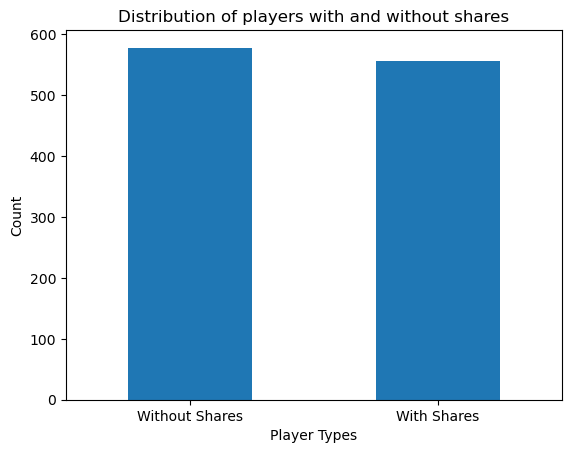

In [ ]:
loc = r'D:\Documents\UofT Civil Engineering\Courses\2022-2023 Fall\CME538\Project 2\dpoy_player_team_stats_1984_2022_final.csv'
df_final = pd.read_csv(loc)
(df_final['Share'] > 0).astype(int).value_counts().plot.bar()
plt.title('Distribution of players with and without shares')
plt.xticks([0,1],['Without Shares', 'With Shares'], rotation=0)
plt.xlabel('Player Types')
plt.ylabel('Count')